# Introduction 

This analytics journal contains some descriptive analytics, data cleaning, and a binary logistic regression model to help the school minimize the data taken into consideration from the parents of the applying child, in order to minimize it as much as they can while keeping the same accuracy.

in other words, we want school evaluators to know what points do they consider the most important and what points don't they do so.

###  Recommendations on data usage 

for starters, the data can generally be used to predict, based on chosen factors, whether a student is going to be enrolled or not. in other words, it can be used to understand how the enrollment committee things and try to find the strongest relationship possible between their decision and the aspects that they consider the most.

examples on how data can be used:
* data can be used to eliminate other data, what we can call "redundant" data --> removing credit_limit_ex_mort because something like credit_limit is enough, because a school enrollment commitee will never accept a student based on the assumption that the father will stop paying ortgage to pay for their school fee.

* data can be aggregated to make the data considered more concise; for example using the "total_salary" to aggregate the father's and mother incomes; same thing have been done with their ratios to the fees.

* data can be discarded compeltely; for example, down_pymnt is a data input based on the decision itself and it introduces a multicollinearity problem, and that is why we chose to eliminate it.

## Problem Definition 

###  How we approached discovering the most contributing factors 

First, we explored the column descriptions and started to color code features that are related to start to correlate them together, identify which will induce multicollinearity, decide probable columns to be aggregated, and identify which of them could be eliminated.

We proceeded to the data cleaning including: outlier detection, removing duplicates, searching for null values. 

then we started aggregating the income features, fees, and the income to fee ratios.

we eliminated the redundant info like the credit score before mortgage.

we eliminated features that we thought were correlated such as the income and years of expereience. 

After that, We proceeded to attempt to draw correlations between certain features that we "thought" could be directly correlated such as the aggregated income (see below). but we could not find linear correlation between these or other features that we thought were less important such as the "address".

after we foudn out there is no linear regression potential and decided to view the problem as a calssification problem using the logistical regression. we added the filtered features, and started to remove one by one starting with the "least" important and noticing the accuracy and precision. we found out that the "down payment" increased the accuracy critically because it introduces multicollinearity here and decided to remove it.

### Why Logistic Regression 

Since we want to put ourselves into the commitee's shoes and see on what crietria/metrics will affect the decision to admit students most. we decided to view the problem as follows:

- all the contribution factors can be "predictors" to the logistic regression
- the decision to enroll or not is a classification between 2 choices



These 2 perceptions made it clear for us to use binary logistic regression to model the problem

The features will be our predictors, and the decision will be our "dependent" variable with a binary value.

Note that a value of 0 means that a student is enrolled.

what we removed
* down payment --> directly corellated, introduces multicollinearity
* job name --> initial filteration, doesnt affect accuracy
* job experience --> corellated with the income
* address --> initial filteration, doesnt affect accuracy
* house_type --> observed it does not affect accuracy

#### a= 61.75%
* credit_limit_ex_mort --> the credit limit after mort is sufficient, and actually more efficient. this makes sense because no father would sell his family's house to pay his son/daughter school fees.

#### a= 61.82%
* number of children: again, what is important is the income and fees.

* total_fees_income_ratio: to calculate such ratio, the school must get the income and the fees. it may be deceiving that it can be sufficient and that we can remove the income and fee columns, but it yields lower accuracy. in reality, such ratio needs the income and fees to be calculated, and that is why we decided to remove it and save the hassle of calculating it anyway.

* spouse_income_verification& salary_verification: observed it doesnt affect
* 'mental_iv_score','parent_iv_score', 'social_iv_score'
* year --> irrelevant
* payment_method --> irrelevant
* spouse_has_job --> what matters is the total balance.
* 'n_semesters' --> what matters is the total balance
* prev_grade_percent --> Surprisingly, does not correlated with acceptance


total income has made (spouce income, father income, job experience) irrelevant
[[ 'app_id', 'job_name', 'job_exp_yrs', 'address',
       'house_type', 'total_salary', 'salary_verification', 'n_semesters',
       'prev_grade_percent', 'total_fees_income_ratio', 'year', 'down_pymnt',
       'fees', 'spouse_has_job', 'total_balance', 'payment_method',
       'num_children', 'credit_limit', 'credit_limit_ex_mort',
       'spouse_income_verification', 'mental_iv_score',
       'parent_iv_score', 'social_iv_score']]
       
out of all these, the model still preserves its 61.82% accuracy with the features of (total income, total balance, fees, and credit limit only) which are the features we decided to keep.       


- 'down_pymnt' causes a multicollinearity problem because it is directly corellated with whether the student has been accepted or not


Accuracy: how many samples were, overall, guesssed correctly
Recall: how many zeroes were predicted as zeroes
Precision: how many 1's were predicted as 1's

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import csv
from datetime import datetime
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json

In [163]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

In [164]:
from datascience import *
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score,recall_score

In [148]:
#loading the data into dataframe
# We have combined the 10 files into one to better handle the data
df = pd.DataFrame(pd.read_csv('./train_International-School-Dataset.csv'))
df_test= pd.DataFrame(pd.read_csv('./test_International-School-Dataset.csv'))
df= df.append(df_test, ignore_index=True)
df.head()

,app_id,job_name,job_exp_yrs,address,house_type,annual_salary,salary_verification,n_semesters,prev_grade_percent,year,fees/income,down_pymnt,fees,spouse_has_job,total_balance,payment_method,num_children,credit_limit,credit_limit_ex_mort,spouse_income,spouse_fees/income,spouse_income_verification,decision,mental_iv_score,parent_iv_score,social_iv_score
0,126229306,Assistant,1.0,YUU,rental,46000.0,V,1,92.65,2017,17.48,0.0,40000.0,Yes,35198.0,credit,3,68039.0,35198.0,110750.0,27.97,V,not enrolled,0.087638,8.423544,32.629941
1,76692947,Nurse,1.0,YUU,rental,152000.0,V,1,93.51,2016,2.39,16000.0,20000.0,No,11704.0,credit,5,24000.0,11704.0,NaN,NaN,NaN,enrolled,25.328459,12.940269,21.888056
2,60624620,engineer,5.0,NXT,rental,115000.0,V,2,88.47,2015,12.95,16000.0,20000.0,No,41004.0,credit,5,67122.0,41004.0,NaN,NaN,NaN,enrolled,7.141356,7.539012,20.730058
3,129161039,manager,2.0,YDC,rental,25000.0,NV,1,89.58,2018,9.75,0.0,20000.0,No,4065.0,credit,2,12000.0,4065.0,NaN,NaN,NaN,not enrolled,34.474615,22.732014,1.076913
4,90518461,Other,6.0,LJM,mortgage,80000.0,V,1,78.51,2016,15.17,21960.0,27450.0,No,169079.0,credit,2,211158.0,32595.0,NaN,NaN,NaN,enrolled,29.070282,5.226745,13.420388


#### Categorical Encoding
we had unique values in categorical columns so we decided to do Label encoding
why label encoding?
it is easier to implement
we have in the job_name 80 unique values, so doing one-hot encoding will increase number of columns dramatically

Note: the decision is encoded to 0 when enrolled and to 1 when not enrolled

In [149]:
df.nunique()

app_id                        36000
job_name                         80
job_exp_yrs                       9
address                          97
house_type                        3
annual_salary                  3045
salary_verification               3
n_semesters                       2
prev_grade_percent              350
year                              7
fees/income                    3876
down_pymnt                      576
fees                            643
spouse_has_job                    2
total_balance                 33112
payment_method                    2
num_children                      6
credit_limit                  30190
credit_limit_ex_mort          28811
spouse_income                   497
spouse_fees/income             1080
spouse_income_verification        3
decision                          2
mental_iv_score               36000
parent_iv_score               36000
social_iv_score               36000
dtype: int64

In [150]:
df_copy = df.copy()

In [151]:

col_list= ["job_name","address", "house_type", "salary_verification", "spouse_income_verification", "spouse_has_job", \
          "spouse_income_verification","payment_method", "year" ,"decision"]
print (col_list)
for item in col_list: 
        df_copy[item]= df_copy[item].astype('category')
        df_copy[item]= df_copy[item].cat.codes



['job_name', 'address', 'house_type', 'salary_verification', 'spouse_income_verification', 'spouse_has_job', 'spouse_income_verification', 'payment_method', 'year', 'decision']


In [152]:
df_copy

,app_id,job_name,job_exp_yrs,address,house_type,annual_salary,salary_verification,n_semesters,prev_grade_percent,year,fees/income,down_pymnt,fees,spouse_has_job,total_balance,payment_method,num_children,credit_limit,credit_limit_ex_mort,spouse_income,spouse_fees/income,spouse_income_verification,decision,mental_iv_score,parent_iv_score,social_iv_score
0,126229306,4,1.0,94,2,46000.0,1,1,92.65,5,17.48,0.0,40000.0,1,35198.0,1,3,68039.0,35198.0,110750.0,27.97,2,1,0.087638,8.423544,32.629941
1,76692947,33,1.0,94,2,152000.0,1,1,93.51,4,2.39,16000.0,20000.0,0,11704.0,1,5,24000.0,11704.0,NaN,NaN,0,0,25.328459,12.940269,21.888056
2,60624620,61,5.0,54,2,115000.0,1,2,88.47,3,12.95,16000.0,20000.0,0,41004.0,1,5,67122.0,41004.0,NaN,NaN,0,0,7.141356,7.539012,20.730058
3,129161039,66,2.0,91,2,25000.0,0,1,89.58,6,9.75,0.0,20000.0,0,4065.0,1,2,12000.0,4065.0,NaN,NaN,0,1,34.474615,22.732014,1.076913
4,90518461,36,6.0,41,0,80000.0,1,1,78.51,4,15.17,21960.0,27450.0,0,169079.0,1,2,211158.0,32595.0,NaN,NaN,0,0,29.070282,5.226745,13.420388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,118191026,59,5.0,36,2,45000.0,0,1,86.41,5,8.91,0.0,22500.0,0,10821.0,1,0,32000.0,10821.0,NaN,NaN,0,1,15.141241,3.351711,29.615634
35996,10414228,30,7.0,14,0,76000.0,1,2,78.52,1,11.38,0.0,34475.0,0,434063.0,1,3,454400.0,34762.0,NaN,NaN,0,1,6.001317,4.968623,15.215748
35997,91763236,-1,6.0,14,0,149500.0,0,1,92.51,4,8.50,16800.0,21000.0,0,624116.0,1,5,644171.0,37491.0,NaN,NaN,0,0,2.645464,66.245158,4.956198
35998,86045897,0,3.0,90,2,86840.0,2,1,85.51,4,8.97,0.0,30000.0,0,171689.0,1,4,194917.0,16419.0,NaN,NaN,0,1,18.686182,0.828035,23.097541


In [153]:
df_copy.isnull().sum()

app_id                            0
job_name                          0
job_exp_yrs                       0
address                           0
house_type                        0
annual_salary                     0
salary_verification               0
n_semesters                       0
prev_grade_percent                0
year                              0
fees/income                       3
down_pymnt                        0
fees                              0
spouse_has_job                    0
total_balance                     0
payment_method                    0
num_children                      0
credit_limit                      0
credit_limit_ex_mort              0
spouse_income                 34624
spouse_fees/income            34624
spouse_income_verification        0
decision                          0
mental_iv_score                   0
parent_iv_score                   0
social_iv_score                   0
dtype: int64

In [154]:
print (df_copy[df_copy['fees/income'].isnull()][['annual_salary', 'decision']])

       annual_salary  decision
9627             0.0         0
21286            1.0         0
21761            0.0         1


In [155]:
print (df_copy[df_copy['annual_salary']<4000][['annual_salary', 'decision']])

       annual_salary  decision
9627             0.0         0
21286            1.0         0
21761            0.0         1
22142         1000.0         0
24489         3412.0         0
24490         2500.0         0
29046         2000.0         0


#### Imputation
As we see above number of nans is pretty high in the two columns spouse_income, and the ratio column after it 
So it makes perfect sense to impute missing values in both columns with zeros
Why?
as it is nan when spouse_has_job is false

For the fees/income table we have three missing values:
the annual_salary is 0 -> and yet two of them are enrolled
yet when we see the spouse salary we found it not zeros
so it makes perfect sense to also impute them with zeros to prepare for the aggregation part

#### Data Aggregation
To handle less columns, we aggregated both spouse and parent salaries and the ratio fees/income corresponding to each
so we have two columns instead of 4


We also dropped the column down_pymnt as it causes issues of biasing with the model ->
that is, down_pymnt is paid when one is enrolled in the school so it makes sense if down_pymnt is there, then the student is enrolled, so this is a causation not a correlation

We also dropped the column credit_limit_ex_mort as the information in credit_limit is enough for the model to work

In [156]:
#spouse_income imputation with zero
df_copy['spouse_income']=df_copy['spouse_income'].fillna(0)
df_copy['spouse_fees/income']=df_copy['spouse_fees/income'].fillna(0)
df_copy['fees/income']=df_copy['fees/income'].fillna(0)

print(df_copy[['spouse_income', 'spouse_fees/income']])

#data Aggregation  begins
try:
    df_salary_col = df_copy['annual_salary'] + df_copy['spouse_income']
    df_copy.insert(5,'total_salary', df_salary_col)
except:
    df_copy['total_salary']= df_copy['annual_salary'] + df_copy['spouse_income']

    
try:
    df_ratio_col = df_copy['fees/income'] + df_copy['spouse_fees/income']
    df_copy.insert(10,'total_fees_income_ratio', df_ratio_col)
except:
    df_copy['total_fees_income_ratio']= df_copy['fees/income'] + df_copy['spouse_fees/income']

pd.set_option("display.max_columns", None)

#droping old columns and down_pymnt,  column credit_limit_ex_mort 
df_copy.drop(['annual_salary', 'spouse_income', 'fees/income', 'spouse_fees/income', 'down_pymnt', 'credit_limit_ex_mort'], inplace=True, axis=1)
df_copy

       spouse_income  spouse_fees/income
0           110750.0               27.97
1                0.0                0.00
2                0.0                0.00
3                0.0                0.00
4                0.0                0.00
...              ...                 ...
35995            0.0                0.00
35996            0.0                0.00
35997            0.0                0.00
35998            0.0                0.00
35999            0.0                0.00

[36000 rows x 2 columns]


,app_id,job_name,job_exp_yrs,address,house_type,total_salary,salary_verification,n_semesters,prev_grade_percent,total_fees_income_ratio,year,fees,spouse_has_job,total_balance,payment_method,num_children,credit_limit,spouse_income_verification,decision,mental_iv_score,parent_iv_score,social_iv_score
0,126229306,4,1.0,94,2,156750.0,1,1,92.65,45.45,5,40000.0,1,35198.0,1,3,68039.0,2,1,0.087638,8.423544,32.629941
1,76692947,33,1.0,94,2,152000.0,1,1,93.51,2.39,4,20000.0,0,11704.0,1,5,24000.0,0,0,25.328459,12.940269,21.888056
2,60624620,61,5.0,54,2,115000.0,1,2,88.47,12.95,3,20000.0,0,41004.0,1,5,67122.0,0,0,7.141356,7.539012,20.730058
3,129161039,66,2.0,91,2,25000.0,0,1,89.58,9.75,6,20000.0,0,4065.0,1,2,12000.0,0,1,34.474615,22.732014,1.076913
4,90518461,36,6.0,41,0,80000.0,1,1,78.51,15.17,4,27450.0,0,169079.0,1,2,211158.0,0,0,29.070282,5.226745,13.420388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,118191026,59,5.0,36,2,45000.0,0,1,86.41,8.91,5,22500.0,0,10821.0,1,0,32000.0,0,1,15.141241,3.351711,29.615634
35996,10414228,30,7.0,14,0,76000.0,1,2,78.52,11.38,1,34475.0,0,434063.0,1,3,454400.0,0,1,6.001317,4.968623,15.215748
35997,91763236,-1,6.0,14,0,149500.0,0,1,92.51,8.50,4,21000.0,0,624116.0,1,5,644171.0,0,0,2.645464,66.245158,4.956198
35998,86045897,0,3.0,90,2,86840.0,2,1,85.51,8.97,4,30000.0,0,171689.0,1,4,194917.0,0,1,18.686182,0.828035,23.097541


In [157]:
df[df['annual_salary']<10]

,app_id,job_name,job_exp_yrs,address,house_type,annual_salary,salary_verification,n_semesters,prev_grade_percent,year,fees/income,down_pymnt,fees,spouse_has_job,total_balance,payment_method,num_children,credit_limit,credit_limit_ex_mort,spouse_income,spouse_fees/income,spouse_income_verification,decision,mental_iv_score,parent_iv_score,social_iv_score
9627,121638456,Other,1.0,YUU,rental,0.0,NV,1,90.56,2017,NaN,22400.0,28000.0,Yes,6253.0,credit,4,18600.0,6253.0,112500.0,4.45,NV,enrolled,44.299313,17.887017,11.538978
21286,120520897,Administrator,1.0,YUU,mortgage,1.0,NV,2,90.07,2017,NaN,32000.0,40000.0,Yes,29019.0,credit,3,52961.0,29019.0,100001.0,9.17,NV,enrolled,0.497568,74.320730,10.003857
21761,118662465,Consultant,1.0,YUU,rental,0.0,NV,1,85.92,2017,NaN,0.0,25850.0,Yes,13664.0,credit,1,35992.0,13664.0,85000.0,19.62,NV,not enrolled,19.762693,29.483812,22.673182


In [158]:
#detect outliars in total_salary
def detect_outliars(df_copy,col):
    upper_limit = df_copy[col].mean() + 6*df_copy[col].std()
    lower_limit = df_copy[col].mean() - 6*df_copy[col].std()
    return df_copy[df_copy[col]> upper_limit], df_copy[df_copy[col]< lower_limit]

C:\Users\maco0\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,app_id,job_name,job_exp_yrs,address,house_type,total_salary,salary_verification,n_semesters,prev_grade_percent,total_fees_income_ratio,year,fees,spouse_has_job,total_balance,payment_method,num_children,credit_limit,spouse_income_verification,decision,mental_iv_score,parent_iv_score,social_iv_score
2073,6126941,-1,6.0,42,2,560000.0,1,1,79.00,8.55,1,35000.0,0,97881.0,1,5,127574.0,0,0,67.810368,19.045506,3.144126
2356,6995979,-1,1.0,94,0,600000.0,2,1,86.32,7.31,1,35000.0,0,788550.0,1,5,885790.0,0,0,23.506793,3.323622,28.056508
2582,85268999,4,9.0,22,0,900000.0,2,1,94.68,2.41,4,24000.0,0,423927.0,1,3,459488.0,0,0,24.838943,22.465658,22.939693
2659,81834434,36,1.0,7,0,900000.0,2,1,92.61,3.57,4,40000.0,0,1977597.0,1,5,2269379.0,0,0,29.559333,13.239886,30.277898
3575,124795557,38,1.0,67,2,650000.0,2,1,93.92,2.06,5,36000.0,0,13566.0,1,2,49100.0,0,0,18.121017,9.165458,51.443103
3600,113847219,20,3.0,94,2,600000.0,1,1,92.03,10.67,5,35000.0,0,56232.0,1,5,206200.0,0,0,3.523718,19.897792,10.763404
3944,97883263,-1,9.0,82,0,1200000.0,2,2,88.51,0.75,5,40000.0,0,423392.0,1,5,514600.0,0,0,44.808097,3.008570,42.183333
4109,43243418,37,6.0,94,1,1900000.0,2,1,93.08,0.21,3,28000.0,0,374848.0,1,5,387937.0,0,0,29.633918,18.917324,7.560457
5105,9577054,36,4.0,26,2,600000.0,2,2,74.11,2.23,1,30225.0,0,60095.0,1,4,72985.0,0,1,10.892567,47.492770,8.991274
5115,38996203,19,5.0,94,2,749810.0,1,2,85.01,5.29,3,30000.0,0,335701.0,1,5,434800.0,0,1,16.050934,26.317464,15.932453


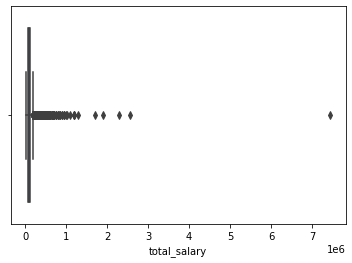

In [159]:
#outliar detection in total_salary
sb.boxplot(df_copy['total_salary'])
salary_upper, salary_lower= detect_outliars(df_copy, 'total_salary')
salary_upper

There is no strange values in the salary outliers, the way to handle these outliars is to keep these rows

C:\Users\maco0\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,app_id,job_name,job_exp_yrs,address,house_type,total_salary,salary_verification,n_semesters,prev_grade_percent,total_fees_income_ratio,year,fees,spouse_has_job,total_balance,payment_method,num_children,credit_limit,spouse_income_verification,decision,mental_iv_score,parent_iv_score,social_iv_score


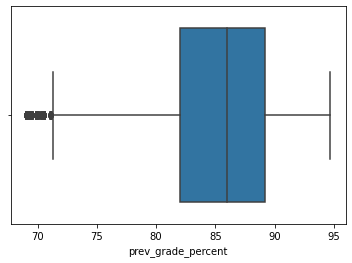

In [182]:
#outliar detection in prev_grade_percent
sb.boxplot(df_copy['prev_grade_percent'])
prev_grade_upper, prev_grade_lower= detect_outliars(df_copy, 'prev_grade_percent')
prev_grade_upper

There is no outliers in the prev_grade column

sum:  2659


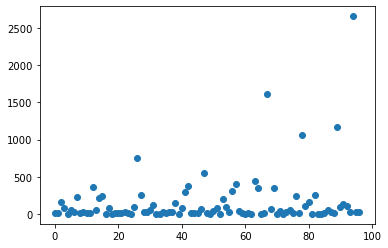

In [205]:
#between the job_name and decision
x = df_copy['address'].unique()

addr_list=[]
sum_list= []
for i in x:
    temp_sum= df_copy[df_copy['address']== i]['decision'].sum()
    addr_list.append(i)
    sum_list.append(temp_sum)

# df_new= pd.DataFrame([addr_list, sum_list],  columns =  ["address", "sum_decision"])    
# print(df_new)
print ("sum: ", df_copy[df_copy['address']== 94]['decision'].sum())

x=addr_list
y = sum_list

plt.scatter(x, y)
plt.show()

We see no correlation whatsoever between the address and the number of students enrolled in the class except for a couple of outliars corresponding to certain areas

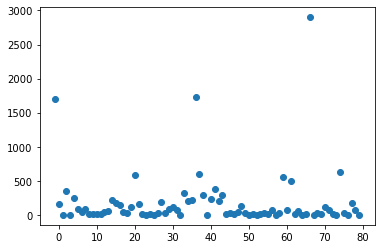

In [206]:
#between the job_name and decision
x = df_copy['job_name'].unique()

addr_list=[]
sum_list= []
for i in x:
    temp_sum= df_copy[df_copy['job_name']== i]['decision'].sum()
    addr_list.append(i)
    sum_list.append(temp_sum)

# df_new= pd.DataFrame([addr_list, sum_list],  columns =  ["address", "sum_decision"])    
# print(df_new)

x=addr_list
y = sum_list

plt.scatter(x, y)
plt.show()

Same here for the parent_job description, no correlation

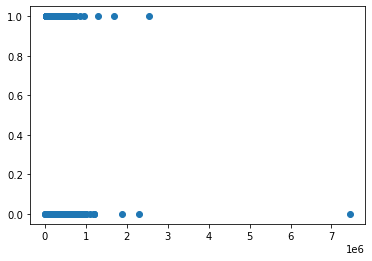

In [207]:
#between total salary and decision
x=df_copy['total_salary']
y = df_copy ['decision']

plt.scatter(x, y)
plt.show()

No correlation between the total_salary and decision whether the student is enrolled or not. 
That is clear from the distribution above as per every point in salary, there is point in the enrolled part and another in the not enrolled part. 

In [161]:
df_copy.describe()

,app_id,job_name,job_exp_yrs,address,house_type,total_salary,salary_verification,n_semesters,prev_grade_percent,total_fees_income_ratio,year,fees,spouse_has_job,total_balance,payment_method,num_children,credit_limit,spouse_income_verification,decision,mental_iv_score,parent_iv_score,social_iv_score
count,3.600000e+04,36000.000000,36000.000000,36000.000000,36000.000000,3.600000e+04,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,3.600000e+04,36000.000000,36000.000000,3.600000e+04,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,6.135554e+07,37.873917,4.078056,61.714694,0.913194,1.029039e+05,1.316500,1.431389,85.404894,16.209351,3.247861,25956.697222,0.038222,1.577637e+05,0.995861,3.127639,1.969337e+05,0.068722,0.416667,20.807006,20.859314,20.995882
std,3.771269e+07,24.653593,2.605142,27.661894,0.942789,7.511867e+04,0.709113,0.495277,5.407741,11.629459,1.399933,5470.974574,0.191735,1.836810e+05,0.064202,1.482684,2.014521e+05,0.385290,0.493013,16.612848,16.657760,16.767061
min,4.058310e+05,-1.000000,1.000000,0.000000,-1.000000,2.000000e+04,0.000000,1.000000,69.010000,0.000000,0.000000,20000.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000667,0.000027,0.000666
25%,3.098701e+07,20.000000,2.000000,42.000000,0.000000,6.500000e+04,1.000000,1.000000,82.030000,9.610000,2.000000,21000.000000,0.000000,3.192825e+04,1.000000,2.000000,5.690000e+04,0.000000,0.000000,7.393123,7.406008,7.479803
50%,6.174902e+07,36.000000,4.000000,67.000000,1.000000,8.660000e+04,1.000000,1.000000,86.010000,14.730000,3.000000,24975.000000,0.000000,7.142300e+04,1.000000,3.000000,1.158595e+05,0.000000,0.000000,16.879523,16.928771,16.975774
75%,8.851330e+07,66.000000,6.000000,89.000000,2.000000,1.200000e+05,2.000000,2.000000,89.220000,20.840000,4.000000,30000.000000,0.000000,2.389735e+05,1.000000,4.000000,2.863445e+05,0.000000,1.000000,30.621452,30.677776,30.859195
max,1.459724e+08,79.000000,9.000000,96.000000,2.000000,7.446395e+06,2.000000,2.000000,94.690000,753.240000,6.000000,40000.000000,1.000000,4.772549e+06,1.000000,5.000000,4.932524e+06,3.000000,1.000000,87.851114,88.246603,88.873714


#### Dictionaries with mapped values for categories

We need to store the mapped value along with its encode number for the test dataset to be encoded the same way using 
the same technique.

In [115]:
mapped_encoded= dict()
for item in col_list:
    temp_df= pd.DataFrame()
    temp_df['new']= df_copy[item]
    temp_df['old']= df[item]
    temp_df.drop_duplicates(inplace= True)
    print (temp_df)
    temp_dict= dict(zip(temp_df['old'],temp_df['new']))
    print (temp_dict)
    mapped_encoded[item]= temp_dict
    print (mapped_encoded)

       new           old
0        4     Assistant
1       33         Nurse
2       61      engineer
3       66       manager
4       36         Other
...    ...           ...
3829    69  photographer
3885    67      musician
5485    72     reception
8778    25   Interpreter
11795   23      Helpdesk

[81 rows x 2 columns]
{'Assistant': 4, 'Nurse': 33, 'engineer': 61, 'manager': 66, 'Other': 36, 'University': 46, 'police': 70, nan: -1, 'Tester': 44, 'sales': 74, 'Owner': 37, 'driver': 59, 'Finance': 21, 'Supervisor': 41, 'Director': 20, 'Specialist': 40, 'Analyst': 2, 'Chef': 13, 'Officer': 34, 'programmer': 71, 'Administrator': 0, 'Court': 16, 'Technician': 43, 'Lead': 27, 'teacher': 77, 'Coordinator': 15, 'Consultant': 14, 'Marketing': 29, 'President': 38, 'accountant': 48, 'Associate': 5, 'Bank': 7, 'WELDER': 47, 'therapist': 78, 'pharmacist': 68, 'Operator': 35, 'Tech': 42, 'Developer': 19, 'Mechanic': 30, 'commercial': 53, 'designer': 56, 'instructor': 63, 'Trainer': 45, 'repairman'

In [117]:
# writing the dictionary to a file
with open('mapped_encoded.txt', 'w') as convert_file:
     convert_file.write(json.dumps(mapped_encoded))

In [132]:
with open('mapped_encoded.txt') as f:
    mapped_decoded = f.read()

#reconstructing the data as a dictionary
mapped_decoded_dict = json.loads(mapped_decoded)

mapped_decoded_dict

{'job_name': {'Assistant': 4,
  'Nurse': 33,
  'engineer': 61,
  'manager': 66,
  'Other': 36,
  'University': 46,
  'police': 70,
  'NaN': -1,
  'Tester': 44,
  'sales': 74,
  'Owner': 37,
  'driver': 59,
  'Finance': 21,
  'Supervisor': 41,
  'Director': 20,
  'Specialist': 40,
  'Analyst': 2,
  'Chef': 13,
  'Officer': 34,
  'programmer': 71,
  'Administrator': 0,
  'Court': 16,
  'Technician': 43,
  'Lead': 27,
  'teacher': 77,
  'Coordinator': 15,
  'Consultant': 14,
  'Marketing': 29,
  'President': 38,
  'accountant': 48,
  'Associate': 5,
  'Bank': 7,
  'WELDER': 47,
  'therapist': 78,
  'pharmacist': 68,
  'Operator': 35,
  'Tech': 42,
  'Developer': 19,
  'Mechanic': 30,
  'commercial': 53,
  'designer': 56,
  'instructor': 63,
  'Trainer': 45,
  'repairman': 73,
  'loader': 65,
  'Customer Service': 17,
  'baker': 49,
  'Medical': 31,
  'electrician': 60,
  'doctor': 58,
  'Biller': 8,
  'Investigator': 26,
  'Carpenter': 12,
  'Human Resources': 24,
  'scientist': 75,
  'Au

In [133]:
type(mapped_decoded_dict)

dict

In [134]:
#mapping the data using the dictionary imported from the file
#REPLACE THE DATAFRAME using the cleaned one
df_mapped= df.copy()
for item in col_list:
    df_mapped[item]= df_mapped[item].replace(mapped_decoded_dict[item])
df_mapped

,app_id,job_name,job_exp_yrs,address,house_type,annual_salary,salary_verification,n_semesters,prev_grade_percent,year,fees/income,down_pymnt,fees,spouse_has_job,total_balance,payment_method,num_children,credit_limit,credit_limit_ex_mort,spouse_income,spouse_fees/income,spouse_income_verification,decision,mental_iv_score,parent_iv_score,social_iv_score
0,126229306,4.0,1.0,49,2.0,46000.0,1,1,92.65,2017,17.48,0.0,40000.0,1,35198.0,1,3,68039.0,35198.0,110750.0,27.97,2.0,1,0.087638,8.423544,32.629941
1,76692947,33.0,1.0,49,2.0,152000.0,1,1,93.51,2016,2.39,16000.0,20000.0,0,11704.0,1,5,24000.0,11704.0,NaN,NaN,NaN,0,25.328459,12.940269,21.888056
2,60624620,61.0,5.0,27,2.0,115000.0,1,2,88.47,2015,12.95,16000.0,20000.0,0,41004.0,1,5,67122.0,41004.0,NaN,NaN,NaN,0,7.141356,7.539012,20.730058
3,129161039,66.0,2.0,48,2.0,25000.0,0,1,89.58,2018,9.75,0.0,20000.0,0,4065.0,1,2,12000.0,4065.0,NaN,NaN,NaN,1,34.474615,22.732014,1.076913
4,90518461,36.0,6.0,20,0.0,80000.0,1,1,78.51,2016,15.17,21960.0,27450.0,0,169079.0,1,2,211158.0,32595.0,NaN,NaN,NaN,0,29.070282,5.226745,13.420388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33995,57383315,2.0,5.0,49,2.0,105000.0,1,1,91.82,2015,11.71,16000.0,20000.0,0,28742.0,1,2,60500.0,28742.0,NaN,NaN,NaN,0,16.907394,64.581258,1.609207
33996,66364198,29.0,3.0,32,0.0,118299.0,1,2,85.52,2015,13.28,19200.0,24000.0,0,330413.0,1,2,470072.0,69265.0,NaN,NaN,NaN,0,65.635700,24.085703,0.278597
33997,23412190,77.0,6.0,41,0.0,56000.0,2,2,85.01,2014,18.88,19200.0,24000.0,0,223575.0,1,4,279870.0,38038.0,NaN,NaN,NaN,0,27.466363,46.752626,15.781011
33998,106575453,66.0,2.0,4,0.0,107100.0,2,1,85.01,2017,3.61,28000.0,35000.0,0,178179.0,1,4,287972.0,17905.0,NaN,NaN,NaN,0,24.455919,3.753729,47.290821


df_copy now contains all the Dataset including the training set and the test set
We split them by indexing the first 34000 element for the train, and 2000 for the test

In [170]:
df_copy2 = df_copy.values([:2000], axis=1)
df_copy2

TypeError: 'numpy.ndarray' object is not callable

In [173]:
# method 1 manually
def split_data(x,y,test_percent=0.2):
    length = int(len(x)*(1-test_percent))
    
#     # first shuflle the data
#     idx = np.random.permutation(x.index)
#     x = x.reindex(idx)
#     y = y.reindex(idx)
    
    xtrain= x.iloc[:length,:]
    xtest= x.iloc[length:, :]
    
    ytrain= y.iloc[:length]
    ytest= y.iloc[length:]
    
    return xtrain,xtest,ytrain,ytest
    


          app_id  total_salary     fees  total_balance  credit_limit
34000   22600619       80000.0  20000.0       180643.0      197427.0
34001    3647199      156000.0  24000.0       717111.0      744266.0
34002   66293500      107000.0  20000.0        30109.0       47410.0
34003   30132830      100000.0  24000.0       361935.0      396600.0
34004  110206107      300000.0  20000.0        38835.0       76600.0
...          ...           ...      ...            ...           ...
35995  118191026       45000.0  22500.0        10821.0       32000.0
35996   10414228       76000.0  34475.0       434063.0      454400.0
35997   91763236      149500.0  21000.0       624116.0      644171.0
35998   86045897       86840.0  30000.0       171689.0      194917.0
35999   55559232       56000.0  22400.0        27783.0       34863.0

[2000 rows x 5 columns]
accuracy: 0.587
recall:  0.315
precision 0.6907894736842105


(2000,)

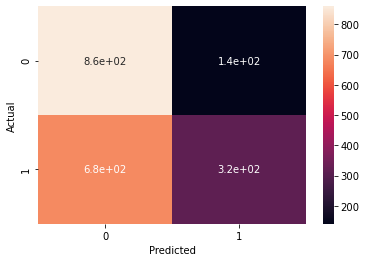

In [180]:
X = df_copy[[ 'app_id','total_salary',
       'fees', 'total_balance', 'credit_limit']]
y = df_copy['decision']

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)
test_percent= 2000/36000
X_train, X_test, y_train, y_test = split_data(X,y,test_percent )
print (X_test)
logistic_regression= LogisticRegression(max_iter=200)
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)


print("accuracy:",accuracy_score(y_pred=y_pred,y_true=y_test))
print("recall: ", recall_score(y_pred=y_pred,y_true=y_test))
print("precision", precision_score(y_pred=y_pred,y_true=y_test))
y_pred.shape

In [94]:
df_copy.to_csv('./school_decision_all_cols_encoded_aggregated.csv')

### Reports on Results

accuracy is 61.18% 
using the 4 most contributing factors to the admission decisions that we left in the model which were: total income, total balance, fees, and credit limit only
we could preserve an accuracy of 61.82%

using the test data, it dropped down to 58.9% and precision is 69%

adding more contribution actors does not raise this accuracy in both cases.

thus, we can conclude that these factors were the "most" contributing to the decisions, and the other factors can be reduced to make the process more concise.


Tips & Recommendations:
    To make the application more concise,
* remove the credit limit pre-mortgage completely
* remove the ratio of each parant alone
* remove the address, year, number of siblings
* job expeirence is usually corellated with income and doesnt affect the decision and should be eliminated. 

    General Recommendations,
* re-evaluate how the grading affects the acceptance
* re-evaluate whether there is a need to verify income to reduce overhead if needed

#### References 

https://datatofish.com/logistic-regression-python/